# Homework 06
### ResNet and DenseNet


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time

from keras.datasets import cifar10
from keras.utils import to_categorical
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Concatenate
from tensorflow.keras import Model
from keras.optimizers import SGD

# Load data

In [2]:
# Load the cifar10 dataset simply works with the function load_data().
(train_inputs, train_labels), (test_inputs, test_labels) = cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [3]:
print(train_inputs.shape)
print(train_labels.shape)

(50000, 32, 32, 3)
(50000, 1)


#Print some examples from the datasets

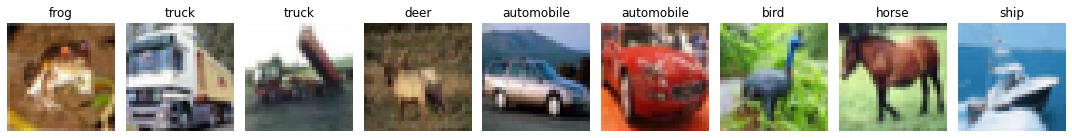

In [4]:
# Names of labels
labels = ['airplane', 
          'automobile',
          'bird',
          'cat',
          'deer',
          'dog',
          'frog',
          'horse',
          'ship',
          'truck']


# Plot examples
_, ax = plt.subplots(1, 9, figsize=(15,15))
for i, img in enumerate(train_inputs[:9]):
  ax[i].imshow(img)
  ax[i].set_title(str(labels[train_labels[i][0]]))
  ax[i].axis('off')

plt.tight_layout()
plt.show()

# Data Augmentation

Augmenting data like this (not generating 'on the fly') but saving them in the data arrays limits data augmentation to approximately 200.000 images as this is where for Google Colab all resources are used. We decided to test if improved accuracies are possible using 50000 augmented images to get a total training set of 100.000 images.

In [5]:
# Initialize data generator:
# Changes in rotation, brightness, shifting in width and height, and flipping horizontally
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range=30,
    brightness_range=(0.4,0.6),
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)

# Create augmented data
train_generator = datagen.flow(train_inputs, train_labels, batch_size=100)

# Create new data arrays - and add augmented images
train_inputs_aug = np.zeros((100000, 32, 32, 3))
train_labels_aug = np.zeros((100000, 1))
train_inputs_aug[:50000,:,:,:] = train_inputs / 255.
train_labels_aug[:50000,:] = train_labels

# Add augmented images
pos = 50000
for i, (image, label) in enumerate(train_generator):

  # Stop after creating 5000 images
  if i >= 50:
    break
  
  train_inputs_aug[pos:pos+100,:,:,:] = image
  train_labels_aug[pos:pos+100] = label

  # Next position
  pos = pos+100


# Print some info on augmented data and show some examples

Training - image shape: (100000, 32, 32, 3), label shape: (100000, 1)
Testing - image shape: (10000, 32, 32, 3), label shape: (10000, 1)


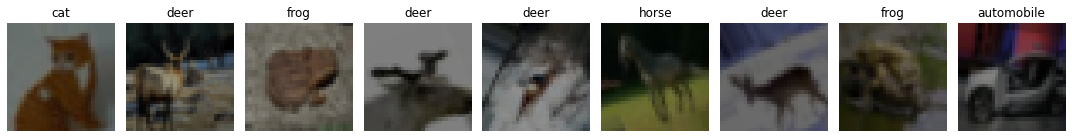

In [6]:
# Show some info and example images
print('Training - image shape: %s, label shape: %s' % (train_inputs_aug.shape, train_labels_aug.shape))
print('Testing - image shape: %s, label shape: %s' % (test_inputs.shape, test_labels.shape))

# Some augmented training images and their labels
_, ax = plt.subplots(1, 9, figsize=(15,15))
for i, img in enumerate(train_inputs_aug[50000:50009]):
  ax[i].imshow(img)
  ax[i].set_title(str(labels[int(train_labels_aug[i+50000])]))
  ax[i].axis('off')

plt.tight_layout()
plt.show()


# Including or excluding augmented data and first data preprocessing

For the final version, we did not need the augmented data. So here, one can find the option to either use also the augmented data or not.

In [7]:
# change dtype
include_augmented_data  = False

if include_augmented_data:
  train_inputs = train_inputs_aug.astype(np.float32)
  train_labels = train_labels_aug.astype(np.uint8)
else:
  train_inputs = train_inputs.astype(np.float32)
  train_labels = train_labels.astype(np.uint8)

test_inputs = test_inputs.astype(np.float32)
test_labels = test_labels.astype(np.uint8)

print(train_inputs.dtype)
print(train_labels.dtype)

print(test_inputs.dtype)
print(test_labels.dtype)

float32
uint8
float32
uint8


#Preprocessing Pipeline

In [8]:
# Preprocess training data
train_inputs_prep = tf.data.Dataset.from_tensor_slices(train_inputs)
train_labels_prep = tf.data.Dataset.from_tensor_slices(train_labels)

# Normalize images and one hot encode the labels
if include_augmented_data:
  train_inputs_prep = train_inputs_prep.map(lambda x: tf.image.per_image_standardization(x))
else:
  train_inputs_prep = train_inputs_prep.map(lambda x: tf.image.per_image_standardization(x/255.))
train_labels_prep = train_labels_prep.map(lambda x: tf.reshape(tf.one_hot(x, 10), (-1,)))

# Batching, shuffling and prefetching
train_data = tf.data.Dataset.zip((train_inputs_prep, train_labels_prep))
train_data = train_data.shuffle(buffer_size=10000)
train_data = train_data.batch(32, drop_remainder=True)
train_data = train_data.prefetch(buffer_size=32)

# Preprocess testing data
test_inputs_prep = tf.data.Dataset.from_tensor_slices(test_inputs)
test_labels_prep = tf.data.Dataset.from_tensor_slices(test_labels)

# Normalize images and one hot encode the labels
test_inputs_prep = test_inputs_prep.map(lambda x : tf.image.per_image_standardization(x/255.))
test_labels_prep = test_labels_prep.map(lambda x: tf.reshape(tf.one_hot(x, 10), (-1,)))

# Batching, shuffling and prefetching
test_data = tf.data.Dataset.zip((test_inputs_prep, test_labels_prep))
test_data = test_data.shuffle(buffer_size=10000)
test_data = test_data.batch(32, drop_remainder=True)
test_data = test_data.prefetch(buffer_size=32)

# ResNet


In [9]:
# activation functions
RELU = tf.keras.activations.relu
SOFTMAX = tf.keras.activations.softmax

class ResidualBlock(Layer):

  def __init__(self, channels):
    """
    Creates a residual layer that consists of three blocks: Each block consists 
    of a convolution, then a batch normalization on th drive and afterwards, the 
    activation function is applied.

    :params:
      channels: Number of channels from input
    """
    super(ResidualBlock, self).__init__()

    self.bottleneck_channels = int(channels / 4) # parameter for bottleneck layer
    self.channels = channels # parameter for channel increase to number of input channels

    # bottleneck layer that halves the number of channels
    self.conv_1 = tf.keras.layers.Conv2D(filters=self.bottleneck_channels, kernel_size=(1,1), activation=None, padding='same')
    self.batch_norm_1 = tf.keras.layers.BatchNormalization()
    self.relu_1 = RELU

    # applying 3x3 convolution on image
    self.conv_2 = tf.keras.layers.Conv2D(filters=self.bottleneck_channels, kernel_size=(3,3), activation=None, padding='same')
    self.batch_norm_2 = tf.keras.layers.BatchNormalization()
    self.relu_2 = RELU

    # increase number of channels back to number of input channels
    self.conv_3 = tf.keras.layers.Conv2D(filters=self.channels, kernel_size=(1,1), activation=None, padding='same')
    self.batch_norm_3 = tf.keras.layers.BatchNormalization()
    self.relu_3 = RELU


  @tf.function
  def call(self, x, training=True):

    y = self.conv_1(x)
    y = self.batch_norm_1(y, training)
    y = self.relu_1(y)

    y = self.conv_2(y)
    y = self.batch_norm_2(y, training)
    y = self.relu_2(y)

    y = self.conv_3(y)
    y = self.batch_norm_3(y, training)
    y = self.relu_3(y)

    # Return sum of original input and residual block output
    return y + x


In [10]:
class ResNet(Model):

  def __init__(self):
    """
    Create a ResNet consisting of four Residual Block. Before each residual 
    block, a convolution that doubles the number of feature channels is applyied 
    and after each residual block follows a Max Pooling layer. The network is 
    finished off with a Global Average Pooling layer and an output layer with 10 
    neurons.
    """
    super(ResNet, self).__init__()

    self.conv_1 =  tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation=RELU, padding='same', input_shape=(32,32,3))
    self.resblock_1 = ResidualBlock(channels=16)
    self.max_pool_1 = tf.keras.layers.MaxPool2D((2,2))

    self.conv_2 =  tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation=RELU, padding='same')
    self.resblock_2 = ResidualBlock(channels=32)
    self.max_pool_2 = tf.keras.layers.MaxPool2D((2,2))

    self.conv_3 =  tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation=RELU, padding='same')
    self.resblock_3 = ResidualBlock(channels=64)
    self.max_pool_3 = tf.keras.layers.MaxPool2D((2,2))

    self.conv_4 =  tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation=RELU, padding='same')
    self.resblock_4 = ResidualBlock(channels=128)
    self.max_pool_4 = tf.keras.layers.MaxPool2D((2,2))

    self.global_pool = tf.keras.layers.GlobalAveragePooling2D()

    # output layer, 10 neurons for the 10 classes, softmax to give the 
    # probability for each class
    self.output_dense = tf.keras.layers.Dense(10, activation=SOFTMAX)

  @tf.function
  def call(self, x, training=True):
    
    x = self.conv_1(x)
    x = self.resblock_1(x, training)
    x = self.max_pool_1(x)

    x = self.conv_2(x)
    x = self.resblock_2(x, training)
    x = self.max_pool_2(x)

    x = self.conv_3(x)
    x = self.resblock_3(x, training)
    x = self.max_pool_3(x)

    x = self.conv_4(x)
    x = self.resblock_4(x, training)
    x = self.max_pool_4(x)

    x = self.global_pool(x)
    x = self.output_dense(x)

    return x


# DenseNet

In [11]:
# activation functions
RELU = tf.keras.activations.relu
SOFTMAX = tf.keras.activations.softmax


# growth rate
k = 32

# number of layers
#L = 100

In [12]:
class TransitionLayer(Layer):
  """
  Transitional Layer between Dense Blocks
  """
  def __init__(self, channels):

    super(TransitionLayer, self).__init__()

    self.channels = channels
    
    self.conv = tf.keras.layers.Conv2D(filters=self.channels, kernel_size=(1,1), activation=None, padding='same')
    self.batch_norm = tf.keras.layers.BatchNormalization()
    self.relu = RELU
    self.pool = tf.keras.layers.AveragePooling2D((2,2), strides=2, padding="same")


  @tf.function
  def call(self, x, training=True):

    x = self.conv(x)
    x = self.batch_norm(x, training)
    x = self.relu(x)
    x = self.pool(x)

    return x

In [13]:
class Block(Layer):
  """
  a block for the dense blocks
  """
  def __init__(self, id, channels):

    super(Block, self).__init__()

    self.id = id

    self.channels = channels
    #self.channels = k + k * (int(self.id) - 1)
    
    self.conv_1 = tf.keras.layers.Conv2D(filters=self.channels , kernel_size=(1,1), activation=None, padding='same')
    self.batch_norm_1 = tf.keras.layers.BatchNormalization()
    self.relu_1 = RELU

    self.conv_2 = tf.keras.layers.Conv2D(filters=self.channels, kernel_size=(3,3), activation=None, padding='same')
    self.batch_norm_2 = tf.keras.layers.BatchNormalization()
    self.relu_2 = RELU

  @tf.function
  def call(self, x, training=True):
    
    x = self.conv_1(x)
    x = self.batch_norm_1(x, training)
    x = self.relu_1(x)

    x = self.conv_2(x)
    x = self.batch_norm_2(x, training)
    x = self.relu_2(x)
    
    return x

In [14]:
class DenseBlock(Layer):
  """
  Dense Block
  """
  def __init__(self, n, channels):

    super(DenseBlock, self).__init__()
    
    # number of blocks
    self.n = n 
    self.blocks = []
    self.channels = channels
    self.concatLayer = tf.keras.layers.Concatenate()

    # create n blocks
    for i in range(self.n):
      self.blocks.append(Block(id=i, channels=self.channels))

    
  @tf.function
  def call(self, x, training=True):

    concat = []
    concat.append(x)

    for i in range(self.n):

      x = self.blocks[i](x, training)
      concat.append(x)
      x = self.concatLayer(concat)

    return x

In [15]:
class DenseNet(Model):
  """
  Densely connected CNN
  """

  def __init__(self):

    super(DenseNet, self).__init__()

    # define layers
    self.conv_1 = tf.keras.layers.Conv2D(filters=k, kernel_size=(3,3), strides=2, activation=RELU, padding='same', input_shape=(32,32,3))
    self.pool_1 = tf.keras.layers.MaxPooling2D((3,3), strides=2, padding='same')

    # 1. dense block and transitional layer
    self.dense_block_1 = DenseBlock(n=1, channels=k)
    self.trans_layer_1 = TransitionLayer(channels=1*k)

    # 2. dense block and transitional layer
    self.dense_block_2 = DenseBlock(n=2, channels=k+k*1)
    self.trans_layer_2 = TransitionLayer(channels=2*k)

    # 3. dense block and transitional layer
    self.dense_block_3 = DenseBlock(n=2, channels=k+k*2)
    self.trans_layer_3 = TransitionLayer(channels=2*k)

    # 4. dense block 
    self.dense_block_4 = DenseBlock(n=1, channels=k+k*3)
    
    # preparing output
    self.batch_norm = tf.keras.layers.BatchNormalization()
    self.relu = RELU
    self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
    self.output_dense = tf.keras.layers.Dense(10, activation=SOFTMAX)


  @tf.function
  def call(self, x, training=True):

    x = self.conv_1(x)
    x = self.pool_1(x)

    #print(x.shape,"after pooling1")

    x = self.dense_block_1(x, training)

    #print(x.shape,"after dense1")
    x = self.trans_layer_1(x, training)

    # print(x.shape,"after trans1")
    x = self.dense_block_2(x, training)
    #print(x.shape, "after dense2")
    x = self.trans_layer_2(x, training)
    #print(x.shape, "after trans2")
    x = self.dense_block_3(x, training)
    #print(x.shape, "after dense3")
    x = self.trans_layer_3(x, training)
    #print(x.shape, "after trans3")

    x = self.dense_block_4(x, training)
    #print(x.shape, "after dense4")

    x = self.batch_norm(x, training)
    x = self.relu(x)
    x = self.global_pool(x)
    x = self.output_dense(x)
   
    return x

In [ ]:
x = tf.ones((1,32,32,3))

dense_test = DenseNet()

dense_test(x)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.1       , 0.1       , 0.1       , 0.09999999, 0.09999999,
        0.09999998, 0.1       , 0.1       , 0.10000003, 0.09999999]],
      dtype=float32)>

In [ ]:
dense_test.summary()

Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
dense_block (DenseBlock)     multiple                  10560     
_________________________________________________________________
transition_layer (Transition multiple                  2208      
_________________________________________________________________
dense_block_1 (DenseBlock)   multiple                  83200     
_________________________________________________________________
transition_layer_1 (Transiti multiple                  10560     
_________________________________________________________________
dense_block_2 (DenseBlock)   multiple                  18

# Training

In [16]:
def train_step(model, input, target, loss_function, optimizer):
  """
  performs one training step
  model :         our model
  input :         the input that is fed into the model
  target :        true label of input
  loss_function : our loss function
  optimizer :     our optimizer
  """
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    accuracy = np.mean(np.argmax(target, axis=1) == np.argmax(prediction, axis=1))
    gradients = tape.gradient(loss, model.trainable_variables)

  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  return np.mean(loss), accuracy 


def test(model, test_data, loss_function):
  """
  test model over complete test data set
  model :         our model
  test_data :     our test data
  loss_function : our loss function
  """

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  # iterate over the test data set and predict each label
  # also calculate loss and accuracy 
  for (input, target) in test_data:

    # For testing, leave out the dropout and Batch Normalization layers by setting training=False
    prediction = model(input, training=False)
    loss = cross_entropy_loss(target, prediction)
    accuracy = np.sum(np.argmax(target, axis=1) == np.argmax(prediction, axis=1)) / target.shape[0]
    test_accuracy_aggregator.append(accuracy)
    test_loss_aggregator.append(loss)

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

# Set hyperparameters and initialize the model

## 1. Training on ResNet

In [19]:
tf.keras.backend.clear_session()

# Hyperparameters
num_epochs = 30
learning_rate = 0.001
running_average_factor = 0.95

model = ResNet()

cross_entropy_loss = tf.keras.losses.categorical_crossentropy
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

# Training the model

In [20]:
# We train for num_epochs epochs.
for epoch in range(num_epochs):

  # Track epoch and time while code runs
  start = time.time()
  print('Epoch: __ ' + str(epoch+1))

  #train_data = train_data.shuffle(buffer_size=256)
  #test_data = test_data.shuffle(buffer_size=256)

  #training (and checking in with training)
  running_average_loss = 0
  running_average_accuracy = 0

  for (input, target) in train_data:
      train_loss, train_accuracy = train_step(model, input, target, cross_entropy_loss, optimizer)
      running_average_loss = running_average_factor * running_average_loss  + (1 - running_average_factor) * train_loss
      running_average_accuracy = running_average_factor * running_average_accuracy  + (1 - running_average_factor) * train_accuracy

  train_losses.append(running_average_loss)
  train_accuracies.append(running_average_accuracy)

  #testing
  test_loss, test_accuracy = test(model, test_data, cross_entropy_loss)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)

  duration = time.time() - start

  # Measure time required for each epoch + show loss and accuracy progress
  print('... finished after %s seconds --- Train loss: %s - Train accuracy: %s --- Test loss: %s - Test accuracy: %s ' % (round(duration, 2), round(running_average_loss, 4), round(running_average_accuracy, 4), round(test_loss, 4), round(test_accuracy, 4)))

Epoch: __ 1
... finished after 53.94 seconds --- Train loss: 1.3409 - Train accuracy: 0.5077 --- Test loss: 2.2004 - Test accuracy: 0.3575 
Epoch: __ 2
... finished after 52.22 seconds --- Train loss: 1.114 - Train accuracy: 0.607 --- Test loss: 1.2785 - Test accuracy: 0.5557 
Epoch: __ 3
... finished after 51.96 seconds --- Train loss: 0.9806 - Train accuracy: 0.6517 --- Test loss: 1.1515 - Test accuracy: 0.5926 
Epoch: __ 4
... finished after 52.63 seconds --- Train loss: 0.9568 - Train accuracy: 0.6527 --- Test loss: 1.0846 - Test accuracy: 0.6224 
Epoch: __ 5
... finished after 52.15 seconds --- Train loss: 0.8523 - Train accuracy: 0.7018 --- Test loss: 1.0189 - Test accuracy: 0.6567 
Epoch: __ 6
... finished after 51.98 seconds --- Train loss: 0.7941 - Train accuracy: 0.7301 --- Test loss: 0.991 - Test accuracy: 0.6599 
Epoch: __ 7
... finished after 52.25 seconds --- Train loss: 0.787 - Train accuracy: 0.727 --- Test loss: 0.8736 - Test accuracy: 0.6962 
Epoch: __ 8
... finished 

In [23]:
# Save losses and accuracies for plotting later
train_losses_res, train_accuracies_res = train_losses[:], train_accuracies[:]
test_losses_res, test_accuracies_res = test_losses[:], test_accuracies[:]

## 2. Training on DenseNet

In [24]:
tf.keras.backend.clear_session()

# Hyperparameters
num_epochs = 30
learning_rate = 0.001
running_average_factor = 0.95

model = DenseNet()

cross_entropy_loss = tf.keras.losses.categorical_crossentropy
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

In [25]:
# We train for num_epochs epochs.
for epoch in range(num_epochs):

  # Track epoch and time while code runs
  start = time.time()
  print('Epoch: __ ' + str(epoch+1))

  #train_data = train_data.shuffle(buffer_size=256)
  #test_data = test_data.shuffle(buffer_size=256)

  #training (and checking in with training)
  running_average_loss = 0
  running_average_accuracy = 0

  for (input, target) in train_data:
      train_loss, train_accuracy = train_step(model, input, target, cross_entropy_loss, optimizer)
      running_average_loss = running_average_factor * running_average_loss  + (1 - running_average_factor) * train_loss
      running_average_accuracy = running_average_factor * running_average_accuracy  + (1 - running_average_factor) * train_accuracy

  train_losses.append(running_average_loss)
  train_accuracies.append(running_average_accuracy)

  #testing
  test_loss, test_accuracy = test(model, test_data, cross_entropy_loss)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)

  duration = time.time() - start

  # Measure time required for each epoch + show loss and accuracy progress
  print('... finished after %s seconds --- Train loss: %s - Train accuracy: %s --- Test loss: %s - Test accuracy: %s ' % (round(duration, 2), round(running_average_loss, 4), round(running_average_accuracy, 4), round(test_loss, 4), round(test_accuracy, 4)))

Epoch: __ 1
... finished after 61.59 seconds --- Train loss: 1.2878 - Train accuracy: 0.5246 --- Test loss: 1.2907 - Test accuracy: 0.5471 
Epoch: __ 2
... finished after 58.15 seconds --- Train loss: 0.9962 - Train accuracy: 0.6525 --- Test loss: 1.136 - Test accuracy: 0.6111 
Epoch: __ 3
... finished after 58.3 seconds --- Train loss: 0.8991 - Train accuracy: 0.6781 --- Test loss: 0.9782 - Test accuracy: 0.6552 
Epoch: __ 4
... finished after 57.98 seconds --- Train loss: 0.8341 - Train accuracy: 0.711 --- Test loss: 0.8409 - Test accuracy: 0.7087 
Epoch: __ 5
... finished after 58.04 seconds --- Train loss: 0.7257 - Train accuracy: 0.7577 --- Test loss: 0.8337 - Test accuracy: 0.7106 
Epoch: __ 6
... finished after 57.96 seconds --- Train loss: 0.6553 - Train accuracy: 0.783 --- Test loss: 0.8772 - Test accuracy: 0.6991 
Epoch: __ 7
... finished after 57.9 seconds --- Train loss: 0.6141 - Train accuracy: 0.7806 --- Test loss: 0.8323 - Test accuracy: 0.7258 
Epoch: __ 8
... finished 

In [26]:
# Save losses and accuracies for plotting later
train_losses_dense, train_accuracies_dense = train_losses[:], train_accuracies[:]
test_losses_dense, test_accuracies_dense = test_losses[:], test_accuracies[:]

# Plot results

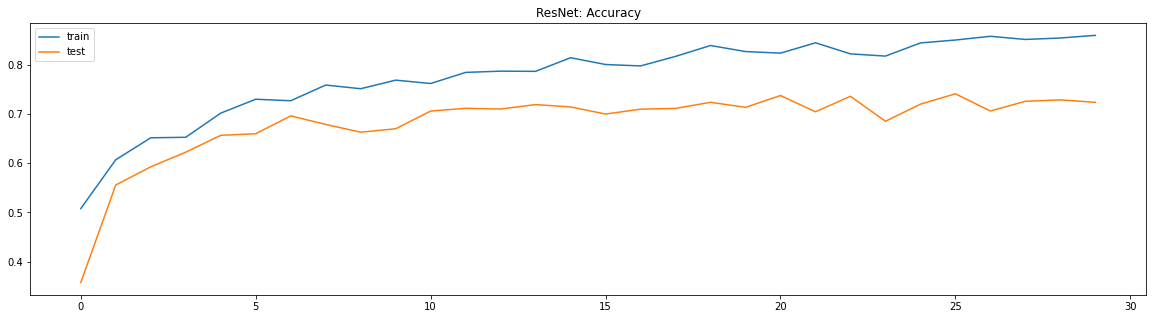

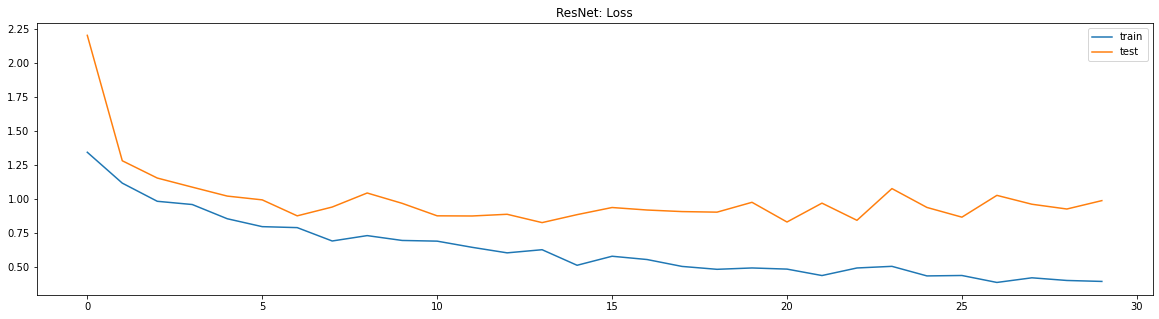

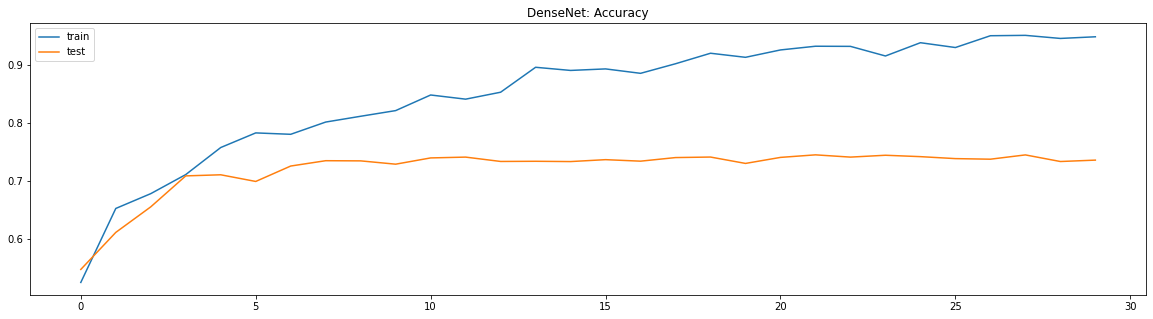

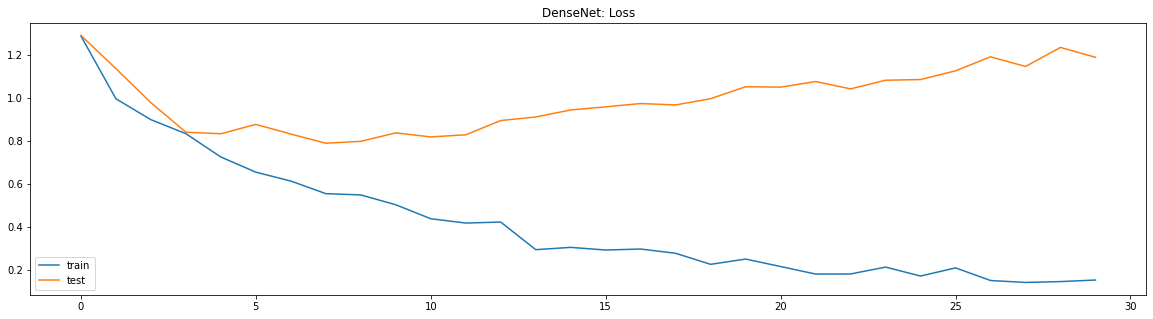

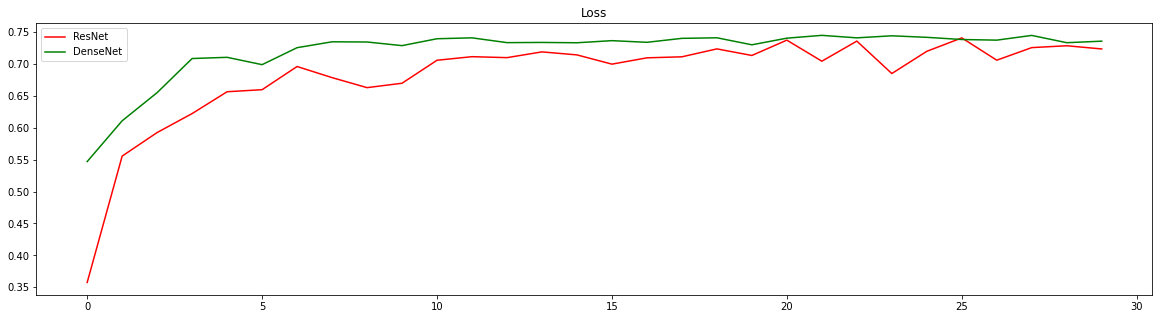

In [28]:
# ResNet accuracies
plt.figure(figsize=(20,5))
plt.plot(train_accuracies_res, label="train")
plt.plot(test_accuracies_res, label="test")
plt.legend()
plt.title("ResNet: Accuracy")
plt.show()

# ResNet losses
plt.figure(figsize=(20,5))
plt.plot(train_losses_res, label="train")
plt.plot(test_losses_res, label="test")
plt.legend()
plt.title("ResNet: Loss")
plt.show()

# DenseNet accuracies
plt.figure(figsize=(20,5))
plt.plot(train_accuracies_dense, label="train")
plt.plot(test_accuracies_dense, label="test")
plt.legend()
plt.title("DenseNet: Accuracy")
plt.show()

# DenseNet losses
plt.figure(figsize=(20,5))
plt.plot(train_losses_dense, label="train")
plt.plot(test_losses_dense, label="test")
plt.legend()
plt.title("DenseNet: Loss")
plt.show()

# Test accuracy comparison ResNet vs DenseNet
plt.figure(figsize=(20,5))
plt.plot(test_accuracies_res, "r", label="ResNet")
plt.plot(test_accuracies_dense, "g", label="DenseNet")
plt.legend()
plt.title("Loss")
plt.show()

In [29]:
x = tf.ones((1,32,32,3))

resnet_test = ResNet()
resnet_test(x)
resnet_test.summary()

Model: "res_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           multiple                  448       
_________________________________________________________________
residual_block (ResidualBloc multiple                  392       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_20 (Conv2D)           multiple                  4640      
_________________________________________________________________
residual_block_1 (ResidualBl multiple                  1328      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_24 (Conv2D)           multiple                  1849

In [30]:
densenet_test = DenseNet()
densenet_test(x)
densenet_test.summary()

Model: "dense_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           multiple                  896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 multiple                  0         
_________________________________________________________________
dense_block_4 (DenseBlock)   multiple                  10560     
_________________________________________________________________
transition_layer_3 (Transiti multiple                  2208      
_________________________________________________________________
dense_block_5 (DenseBlock)   multiple                  83200     
_________________________________________________________________
transition_layer_4 (Transiti multiple                  10560     
_________________________________________________________________
dense_block_6 (DenseBlock)   multiple                  